<a href="https://colab.research.google.com/github/Baraa-Rayed/ECG-Arrhythmia-Classification/blob/main/Copy_of_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication study of "ECG Heartbeat Classification: A Deep Transferable Representation"

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

# Move data from Drive to /tmp

In [ ]:
# You can obtain the data from Kaggle at https://www.kaggle.com/shayanfazeli/heartbeat
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Mounted at /tmp/drive
unzip:  cannot find or open /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip, /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip.zip or /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip.ZIP.
ls: cannot access '/tmp/ecg': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! unzip "/content/drive/MyDrive/archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Mounted at /content/drive
Archive:  /content/drive/MyDrive/archive.zip
  inflating: /tmp/ecg/mitbih_test.csv  
  inflating: /tmp/ecg/mitbih_train.csv  
  inflating: /tmp/ecg/ptbdb_abnormal.csv  
  inflating: /tmp/ecg/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arhythmia dataset

In [ ]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [ ]:
mitbih_train.shape
print(mitbih_train)

            0         1         2         3         4         5         6    \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7         8         9    ...  178  179 

### Explore feature and label distribution

In [ ]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
print(mitbih_train_labels)

0        N
1        N
2        N
3        N
4        N
        ..
87549    Q
87550    Q
87551    Q
87552    Q
87553    Q
Name: 187, Length: 87554, dtype: object


Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

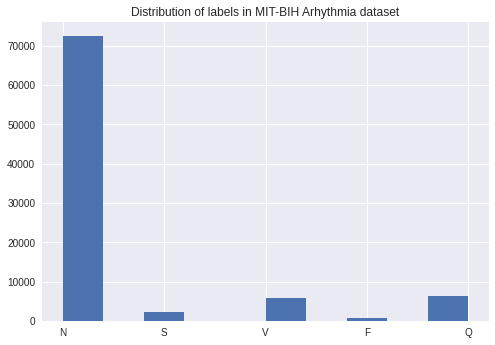

In [ ]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

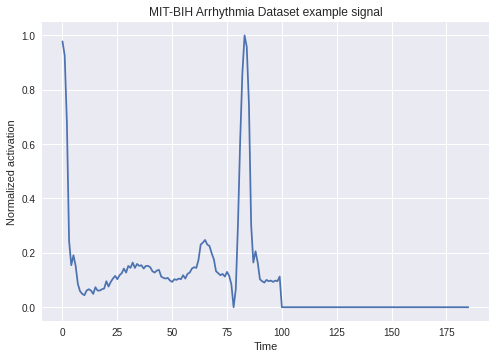

In [ ]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

### Explore data quality

In [ ]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [ ]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


## PTB Diagnostic ECG Database

In [ ]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

In [ ]:
ptbdb.shape

(14552, 188)

In [ ]:
ptbdb_abnormal.values[:,-1] # Abnormal is labelled one as per convention

array([1., 1., 1., ..., 1., 1., 1.])

### Explore features and labels

In [ ]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

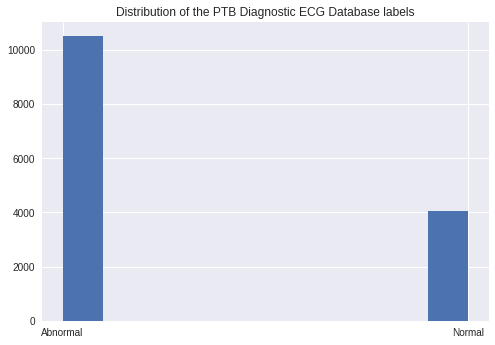

In [ ]:
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

### Explore data quality

In [ ]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [ ]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

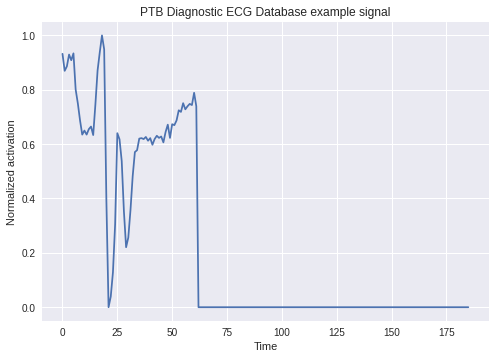

In [ ]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

# Helper functions

In [ ]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Baseline MLP

In [ ]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))
  ])

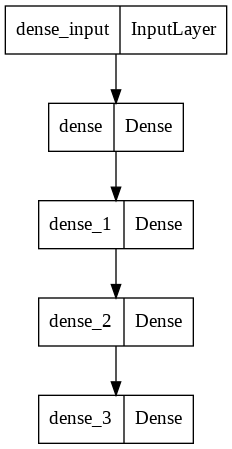

In [ ]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

## Baseline PTB check

In [ ]:
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)

print("All features size {}".format(ptbdb.iloc[:,:-1].shape))
print("Train features size {}".format(X_ptbdb_train.shape))
print("Validation features size {}".format(X_ptbdb_val.shape))
print("Test features size {}".format(X_ptbdb_test.shape))

All features size (14552, 187)
Train features size (11641, 187)
Validation features size (1455, 187)
Test features size (1456, 187)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


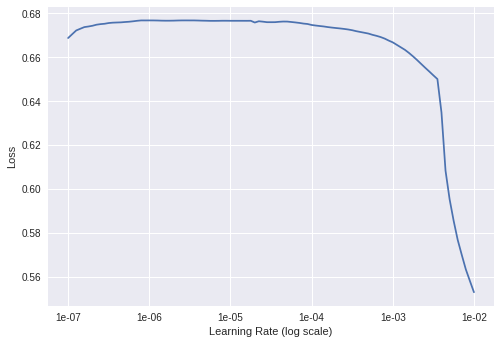

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
# Set cyclical learning rate
N = X_ptbdb_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model()
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val),
                         shuffle=True, batch_size=batch_size, epochs=150, callbacks=[save_best_weights])

Epoch 1/150
91/91 [==============================] - 1s 5ms/step - loss: 0.6648 - accuracy: 0.6527 - val_loss: 0.5372 - val_accuracy: 0.7409
Epoch 2/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.7685 - val_loss: 0.4080 - val_accuracy: 0.7938
Epoch 3/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8160 - val_loss: 0.3783 - val_accuracy: 0.8254
Epoch 4/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3624 - accuracy: 0.8401 - val_loss: 0.3674 - val_accuracy: 0.8282
Epoch 5/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3497 - accuracy: 0.8486 - val_loss: 0.3518 - val_accuracy: 0.8440
Epoch 6/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8618 - val_loss: 0.3307 - val_accuracy: 0.8502
Epoch 7/150
91/91 [==============================] - 0s 4ms/step - loss: 0.2977 - accuracy: 0.8711 - val_loss: 0.2919 - val_accuracy: 0.8777
Epoch 8/150
9

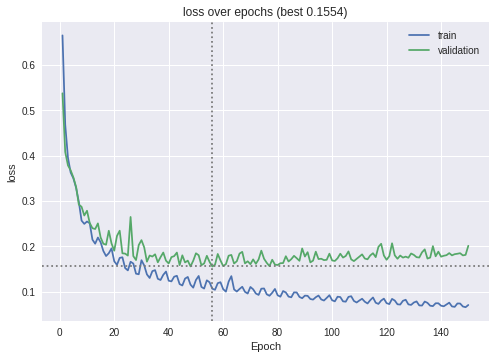

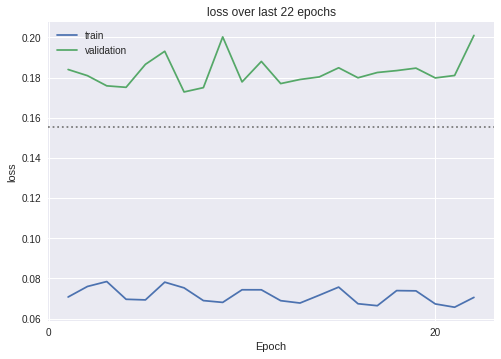

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

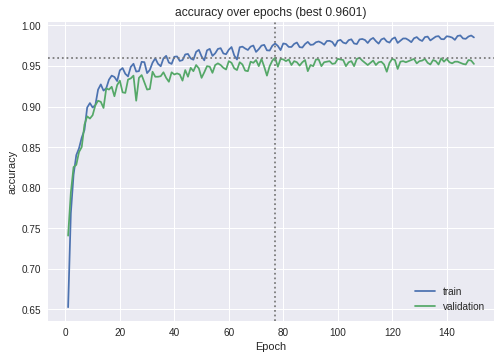

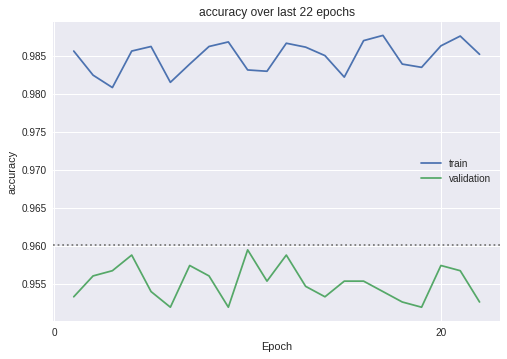

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_ptbdb_test, y_ptbdb_test)

46/46 [==============================] - 0s 3ms/step - loss: 0.1404 - accuracy: 0.9595


[0.1404343545436859, 0.9594780206680298]

Confusion matrix, without normalization
[[ 353   32]
 [  27 1044]]


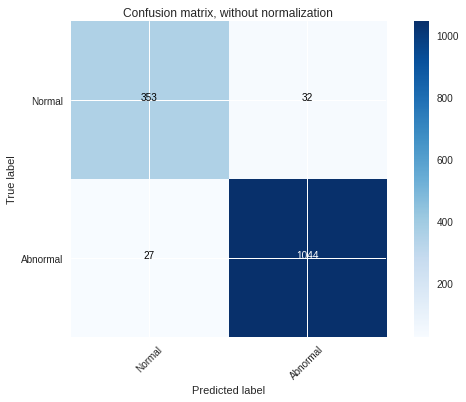

In [ ]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

# ResNet model

In [ ]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

## ResNet PTB replication

In [ ]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


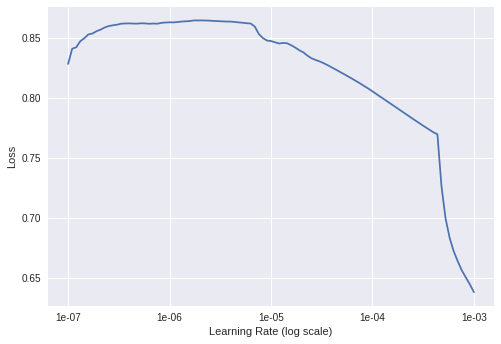

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
# Set cyclical learning rate
N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model()
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val),
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
91/91 [==============================] - 4s 21ms/step - loss: 0.5924 - accuracy: 0.6493 - val_loss: 0.4450 - val_accuracy: 0.7863
Epoch 2/75
91/91 [==============================] - 1s 9ms/step - loss: 0.3353 - accuracy: 0.8539 - val_loss: 0.2312 - val_accuracy: 0.9113
Epoch 3/75
91/91 [==============================] - 1s 9ms/step - loss: 0.1930 - accuracy: 0.9282 - val_loss: 0.1484 - val_accuracy: 0.9505
Epoch 4/75
91/91 [==============================] - 1s 9ms/step - loss: 0.1140 - accuracy: 0.9593 - val_loss: 0.0919 - val_accuracy: 0.9670
Epoch 5/75
91/91 [==============================] - 1s 9ms/step - loss: 0.0940 - accuracy: 0.9681 - val_loss: 0.0836 - val_accuracy: 0.9766
Epoch 6/75
91/91 [==============================] - 1s 9ms/step - loss: 0.1091 - accuracy: 0.9585 - val_loss: 0.1020 - val_accuracy: 0.9622
Epoch 7/75
91/91 [==============================] - 1s 9ms/step - loss: 0.0795 - accuracy: 0.9730 - val_loss: 0.0459 - val_accuracy: 0.9869
Epoch 8/75
91/91 [=

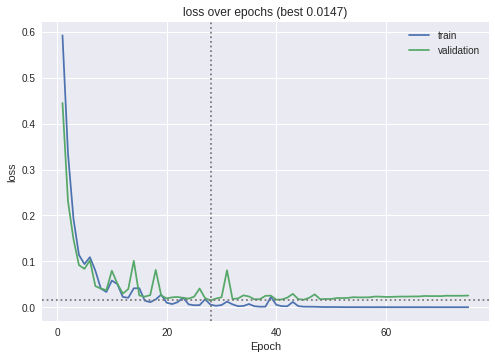

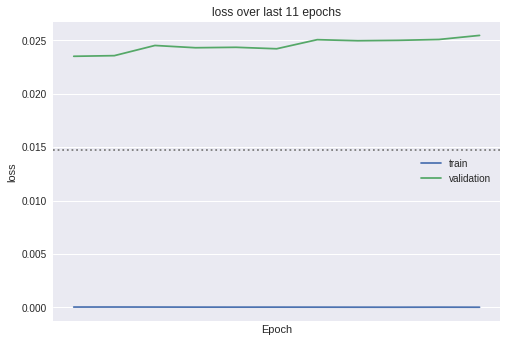

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

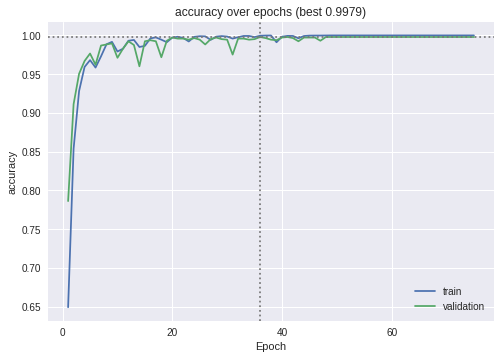

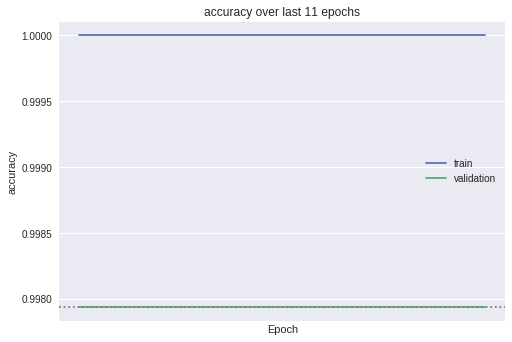

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

46/46 [==============================] - 0s 5ms/step - loss: 0.0108 - accuracy: 0.9959


[0.010796191170811653, 0.9958791136741638]

Confusion matrix, without normalization
[[ 383    2]
 [   4 1067]]


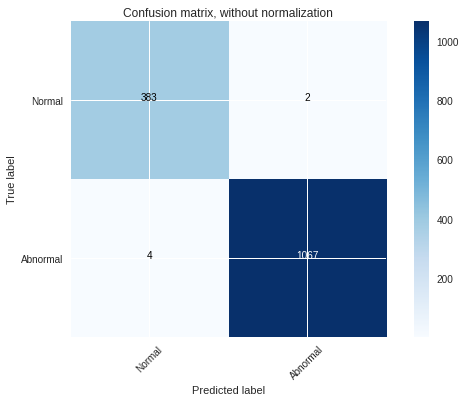

In [ ]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH replication

In [ ]:
print(mitbih_train)
print(mitbih_train.iloc[:,:-1].values)

            0         1         2         3         4         5         6    \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7         8         9    ...  178  179 

In [ ]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


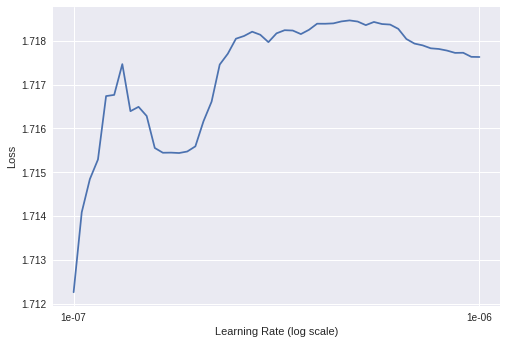

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val),
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
616/616 [==============================] - 8s 9ms/step - loss: 0.3694 - accuracy: 0.8892 - val_loss: 0.2329 - val_accuracy: 0.9360
Epoch 2/50
616/616 [==============================] - 5s 8ms/step - loss: 0.1427 - accuracy: 0.9615 - val_loss: 0.1431 - val_accuracy: 0.9585
Epoch 3/50
616/616 [==============================] - 5s 8ms/step - loss: 0.1165 - accuracy: 0.9689 - val_loss: 0.1027 - val_accuracy: 0.9703
Epoch 4/50
616/616 [==============================] - 5s 8ms/step - loss: 0.0966 - accuracy: 0.9740 - val_loss: 0.1017 - val_accuracy: 0.9725
Epoch 5/50
616/616 [==============================] - 5s 9ms/step - loss: 0.0837 - accuracy: 0.9774 - val_loss: 0.0989 - val_accuracy: 0.9736
Epoch 6/50
616/616 [==============================] - 5s 8ms/step - loss: 0.0780 - accuracy: 0.9786 - val_loss: 0.0783 - val_accuracy: 0.9773
Epoch 7/50
616/616 [==============================] - 9s 14ms/step - loss: 0.0714 - accuracy: 0.9803 - val_loss: 0.0810 - val_accuracy: 0.9777
Epoch

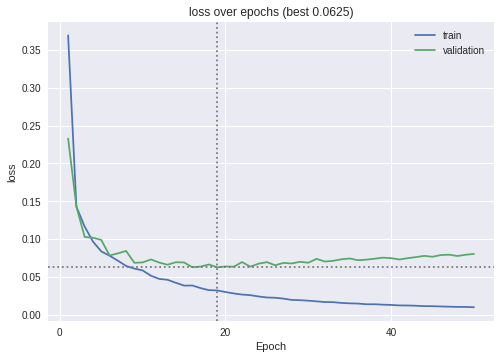

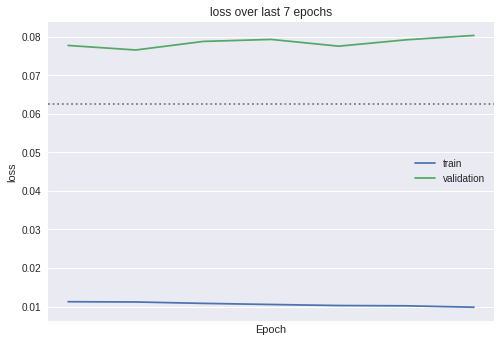

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

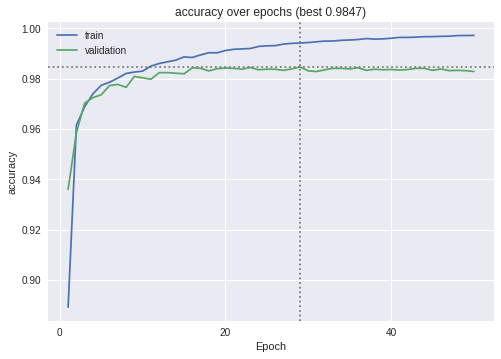

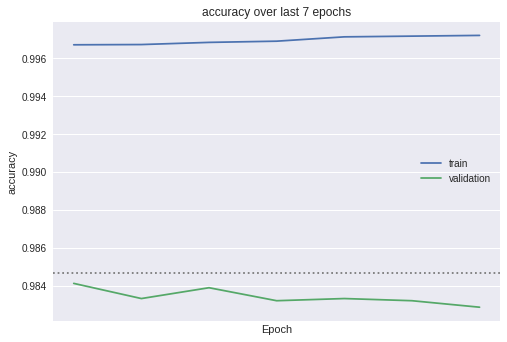

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 3s 4ms/step - loss: 0.0617 - accuracy: 0.9843


Confusion matrix, without normalization
[[18056    37    19     4     2]
 [  129   419     7     0     1]
 [   44    12  1374    15     3]
 [   28     0    18   116     0]
 [   21     1     3     0  1583]]


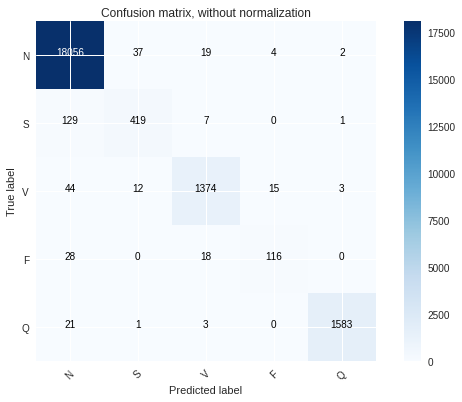

In [ ]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

# Transfer learning application

In [ ]:
m_resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 183, 32)      192         ['input_4[0][0]']                
                                                                                                  
 conv1d_34 (Conv1D)             (None, 183, 32)      5152        ['conv1d_33[0][0]']              
                                                                                                  
 re_lu_30 (ReLU)                (None, 183, 32)      0           ['conv1d_34[0][0]']              
                                                                                            

In [ ]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(32, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 183, 32)      192         ['input_4[0][0]']                
                                                                                                  
 conv1d_34 (Conv1D)             (None, 183, 32)      5152        ['conv1d_33[0][0]']              
                                                                                                  
 re_lu_30 (ReLU)                (None, 183, 32)      0           ['conv1d_34[0][0]']              
                                                                                            

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(m_resnet_model)

save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val),
                             shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
91/91 [==============================] - 2s 9ms/step - loss: 0.5198 - accuracy: 0.7514 - val_loss: 0.3666 - val_accuracy: 0.8296
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.3512 - accuracy: 0.8407 - val_loss: 0.3369 - val_accuracy: 0.8412
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.3167 - accuracy: 0.8632 - val_loss: 0.2994 - val_accuracy: 0.8653
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.2930 - accuracy: 0.8736 - val_loss: 0.2940 - val_accuracy: 0.8674
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.2763 - accuracy: 0.8803 - val_loss: 0.2662 - val_accuracy: 0.8832
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.2769 - accuracy: 0.8810 - val_loss: 0.2573 - val_accuracy: 0.8935
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.2535 - accuracy: 0.8931 - val_loss: 0.2541 - val_accuracy: 0.8852
Epoch 8/100
9

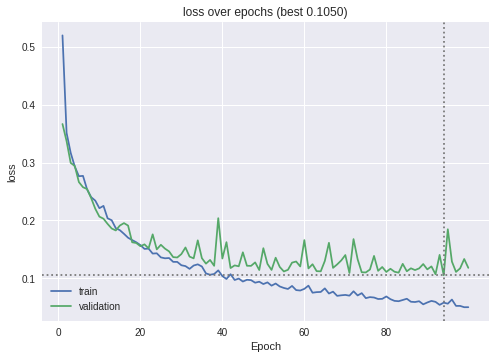

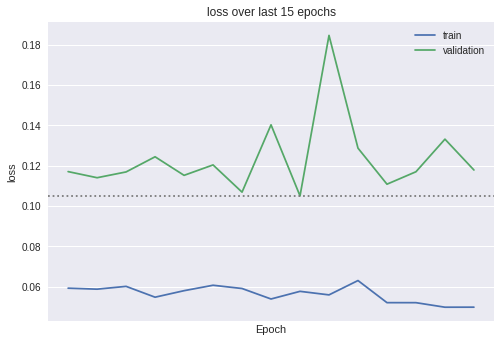

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

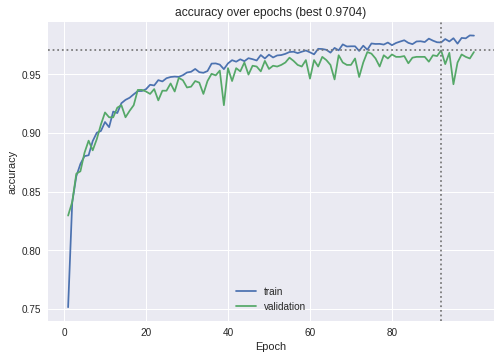

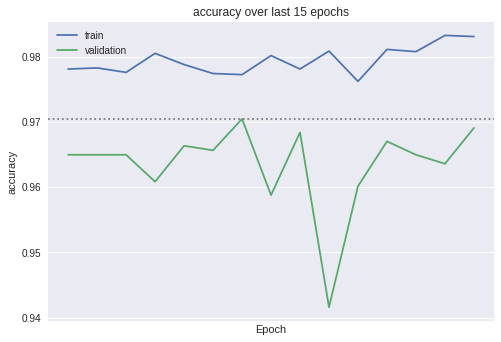

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
transfer_model.load_weights('tweights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test)

46/46 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9636


[0.0883592739701271, 0.963598906993866]

Confusion matrix, without normalization
[[ 354   31]
 [  22 1049]]


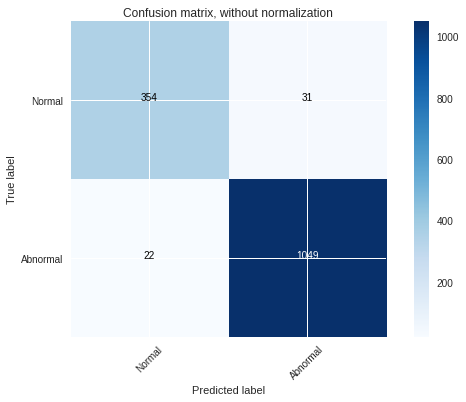

In [ ]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')